# All the imports

In [3]:
from tensorflow.compat.v1.keras import models, layers, losses, optimizers
#tensorflow 1.15 used since DirectML library supports only tensorflow 1.15 for now
from tensorflow.compat.v1.keras.layers import Conv2D, Lambda, Input, UpSampling2D 
from tensorflow.compat.v1.keras.layers import MaxPool2D, Dropout, concatenate, BatchNormalization
from tensorflow.compat.v1.keras.layers import Activation, Conv2DTranspose, Concatenate
import tensorflow.compat.v1 as tf
import mat73
import numpy as np
from tensorflow.compat.v1 import keras
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy.io import savemat, loadmat
import tensorflow.keras.backend as K
from  tensorflow.compat.v1.keras.callbacks import CSVLogger
import SimpleITK as sitk
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# Imports below this can be commented when running since it is for using GPU
from tensorflow.python.client import device_lib
tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True)) 
tf.config.set_soft_device_placement(False)

# Import the data File and preprocess it

In [42]:
data = mat73.loadmat("./stacked_data.mat") # load preprocessed Data

### Helper function to remove images without the given dimensions

In [ ]:
def filter_diff(X,y,y_mask, size): 
    """ 
    Some images in the dataset aren't of the shape (512,512).
    This function removes those images.
    
    """
    j=len(X)-1;
    while j>=0:
        if X[j].shape != size:
            del X[j];
            del y[j];
            del y_mask[j];
        else:
            j-=1;

### Min-Max Normalizing Function

In [ ]:
def normalize_minMax(X):
    """
    Normalize using Min-Max Normalization
    """
    mini = X.min();
    maxi = X.max();
    return (X- mini)/(maxi-mini);

### n4 Bias Field Correcting Function

In [ ]:
def remove_bias(X):
    """
    Correcting Bias Field using SimpleITK's N4BiasFieldCorrectionImageFilter class.
    """
    result = []
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrector.SetConvergenceThreshold(0.01)
    corrector.SetMaximumNumberOfIterations([100,100,100,100])
    for i in range(len(X)):
        print(i)
        img = sitk.GetImageFromArray(np.reshape(X[i], (512,512)))
        img = sitk.Cast(img, sitk.sitkFloat32)
        a = sitk.GetArrayFromImage(corrector.Execute(img))
        result.append(a)
    return result;

### Putting it all together

In [ ]:
# get x, y and ymask from the stacked mat file where all images are
X = [i["image"] for i in data["data"]["cjdata"]];  
y_mask = [i["tumorMask"] for i in data["data"]["cjdata"]];
y = [i["label"] for i in data["data"]["cjdata"]];
 # filter out images of different dimensions
filter_diff(X,y,y_mask, (512,512));
X = normalize_minMax(np.array(X));# normalize the x
X = remove_bias(X);# remove bias from X
#resizing x and y_mask for the input layer in the networks
X = np.reshape(X,(len(X),X[0].shape[0],X[0].shape[1],1)); 
# change y from denoting class as a number to a hot encoded binary matrix
y = keras.utils.to_categorical(np.array(data["y"])-1,3)
y_mask = np.array(y_mask).astype(int);
y_mask =np.reshape(y_mask,(len(y_mask),y_mask[0].shape[0],y_mask[0].shape[1],1));
y_mask = tf.image.resize(y_mask, (324,324)).numpy();
# saving the file so it can be shared
savemat("./N4Corrected2.mat", {"X":X, "y":y, "y_mask":y_mask})

# After Preprocessing

In [128]:
data= loadmat("./N4Corrected2.mat"); # loading preprocessed dataset

In [129]:
X = data["X"] #get the saved vars from the saved preprocessed object
y_mask = data["y_mask"]
y = data["y"]
#split train test 
X_train, X_test, y_train, y_test = train_test_split(X, y_mask, test_size=0.2)

### Loss functions 

In [147]:
def sensitivity( y_true, y_pred):
    """
            True Postive
    -----------------------------
    True Postive + False Negatives
    """
    
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    AP = K.sum(K.round(K.clip(y_true, 0, 1)))
    return TP / (AP + K.epsilon()) # epsilon added to aviod divide by 0 error.

def specificity( y_true, y_pred):
    """
            True Negative
    -----------------------------
    True Negative + False Positives
    """
    
    TN = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    AN = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return TN / (AN + K.epsilon()) # epsilon added to aviod divide by 0 error.

def dice_score( y_true, y_pred):
    """
    Calcutes the amount of overlapping two images have
    """
    flat_true = K.flatten(y_true)
    flat_pred = K.flatten(y_pred)
    intersection = K.sum(flat_true * flat_pred)
    return (2. * intersection + K.epsilon()) / (
                K.sum(flat_true) + K.sum(flat_pred) + K.epsilon())

def loss_dice( y_true, y_pred):
    """
    1 minus dice score gives us a number between 0 and 1. When score is low, cost is high, 
    whereas, when score is high loss is low.
    This was used to train/penalize the model based on the coefficient.
    """
    loss = 1 - dice_score(y_true, y_pred)
    return loss

def loss_WCE(y_true, y_pred):
    """
     Weighted cross entropy used to give more weight to false negatives using beta value 
     greater than 1. Here, beta is denoted
     by the constant beta.
    """
    beta = 30;
    y_trueFl32=tf.cast(y_true, tf.float32);
    y_predFl32=tf.cast(y_true, tf.float32);
    weight_a = beta * y_trueFl32;
    weight_b = 1 - y_predFl32;

    loss = (tf.math.log1p(tf.exp(-tf.abs(y_pred))) + tf.nn.relu(-y_pred)) * (weight_a + weight_b) + y_pred * weight_b 
    return tf.reduce_mean(loss);

# Building the U-net

In [130]:
def unet(input_size) : #follows the U-net Architecture
    inputs = Input(input_size)
    c1 = Conv2D(64, 3, activation = 'relu')(inputs)
    c1 = Conv2D(64, 3, activation = 'relu')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPool2D(pool_size=(2, 2))(c1)
    c2 = Conv2D(128, 3, activation = 'relu')(p1)
    c2 = Conv2D(128, 3, activation = 'relu')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPool2D(pool_size=(2, 2))(c2)
    c3 = Conv2D(256, 3, activation = 'relu')(p2)
    c3 = Conv2D(256, 3, activation = 'relu')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPool2D(pool_size=(2, 2))(c3)
    c4 = Conv2D(512, 3, activation = 'relu')(p3)
    c4 = Conv2D(512, 3, activation = 'relu')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPool2D(pool_size=(2, 2))(c4)

    conv5 = Conv2D(1024, 3, activation = 'relu')(p4)
    conv5 = Conv2D(1024, 3, activation = 'relu')(conv5)

    T6 = Conv2DTranspose(1024, 2, activation = 'relu', strides=(2,2))(conv5)
    crop4 = tf.image.resize(c4, (T6.shape[1],T6.shape[2]))
    merge7 = concatenate([crop4,T6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu')(T6)
    conv6 = Conv2D(512, 3, activation = 'relu')(conv6)
    conv6 = BatchNormalization()(conv6)

    T7 = Conv2DTranspose(512, 2, activation = 'relu',strides=(2,2))(conv6)
    crop3 = tf.image.resize(c3, (T7.shape[1],T7.shape[2]))
    merge7 = concatenate([crop3,T7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu')(conv7)
    conv7 = BatchNormalization()(conv7)

    T8 = Conv2DTranspose(256, 2, activation = 'relu',strides=(2,2))(conv7)
    crop2 = tf.image.resize(c2, (T8.shape[1],T8.shape[2]))
    merge8 = concatenate([crop2,T8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu')(conv8)
    conv8 = BatchNormalization()(conv8)

    T9 = Conv2DTranspose(128, 2, activation = 'relu',strides=(2,2))(conv8)
    crop1 = tf.image.resize(c1, (T9.shape[1],T9.shape[2]))
    merge9 = concatenate([crop1,T9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu')(conv9)
    conv9 = BatchNormalization()(conv9)
    c10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = keras.Model(inputs = inputs, outputs = c10)

    model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.01), loss = loss_WCE, metrics = ['accuracy', dice_score, sensitivity, specificity])

    
    return model

### Compiling the U-net

In [131]:
model = unet((512,512,1))

Executing op __inference_keras_scratch_graph_83035 in device /job:localhost/replica:0/task:0/device:DML:0
Executing op __inference_keras_scratch_graph_83262 in device /job:localhost/replica:0/task:0/device:DML:0
Executing op __inference_keras_scratch_graph_83489 in device /job:localhost/replica:0/task:0/device:DML:0
Executing op __inference_keras_scratch_graph_83716 in device /job:localhost/replica:0/task:0/device:DML:0


In [135]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 510, 510, 64) 640         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 508, 508, 64) 36928       conv2d_95[0][0]                  
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 508, 508, 64) 256         conv2d_96[0][0]                  
____________________________________________________________________________________________

### Training the U-net

In [ ]:
# saves training metrics to compare later
CSV = CSVLogger("training_test", separator=',', append=True) 
# trains the model with X_train and y_train
history = model.fit(X_train, y_train, epochs=5, batch_size=8, steps_per_epoch=305, callbacks = [CSV]) 

### Saving the model for future use

In [38]:
# after finding a decent model, it is always saved for later use and sharing
model.save("./WeightedCross55epochs") 

### Loading a pre-existing Model

In [134]:
# loading the model previously saved
model = models.load_model("./WeightedCross50epochs", custom_objects={
    "loss_WCE":loss_WCE, "specificity":specificity, "sensitivity":sensitivity, "dice_coef":dice_score})

### Saving the predictions

In [32]:
result = {"result": predictions}
savemat("./result_dice.mat", result)

# Evaluations

In [110]:
model.evaluate(X_test, y_test, batch_size=8)

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_68073 in device /job:localhost/replica:0/task:0/device:DML:0
610/1 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.8652532931234016, 0.98989314, 0.7658848, 0.9684752, 0.9145486, 0.9917237]

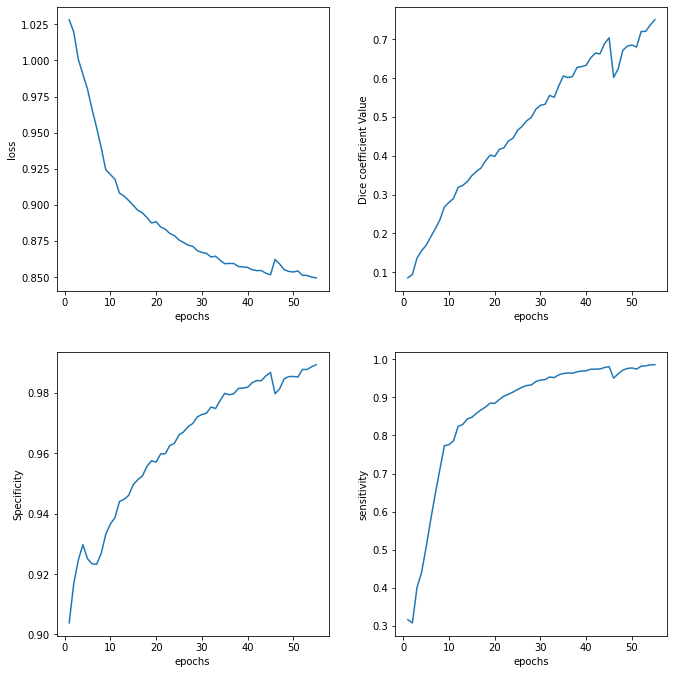

In [7]:
epochs = range(len(nhistory))
fig, axes = plt.subplots(2,2, figsize=(10,10))
axes[0][0].plot(epochs, total_loss)
axes[0][0].set_ylabel("loss")
axes[0][1].plot(epochs, total_dice_coef)
axes[0][1].set_ylabel("Dice coefficient Value")
axes[1][0].plot(epochs, total_specificity)
axes[1][0].set_ylabel("Specificity")
axes[1][1].plot(epochs, total_sensitivity)
axes[1][1].set_ylabel("sensitivity")
for i in range(len(axes)):
    for j in range(len(axes[i])):
        axes[i][j].set_xlabel("epochs")
fig.tight_layout(pad=3.0)

In [4]:
nhistory = np.genfromtxt("./training_weightedCross", delimiter=",")

In [6]:
#assigning the metric values we got to each of these variable in order 
#view the increase/decrease of the metrics
#over the whole training set
total_dice_coef=[]
total_loss=[]
total_specificity=[]
total_sensitivity=[]
for i in range(len(nhistory)):
    total_dice_coef.append(nhistory[i][3])
    total_loss.append(nhistory[i][4])
    total_specificity.append(nhistory[i][6])
    total_sensitivity.append(nhistory[i][5])

In [136]:
# using the model to predict y_mask for the corresponding X
predictions =model.predict(X_test,batch_size=8);

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_95265 in device /job:localhost/replica:0/task:0/device:DML:0


In [145]:
# Create an array of random number between the range of 0 and 
#length of predictions with the size of 5 to
#help show true and predicted masks
random_index = np.random.randint(0, len(predictions), size = 5)
random_index

array([ 71, 233, 104, 275, 204])

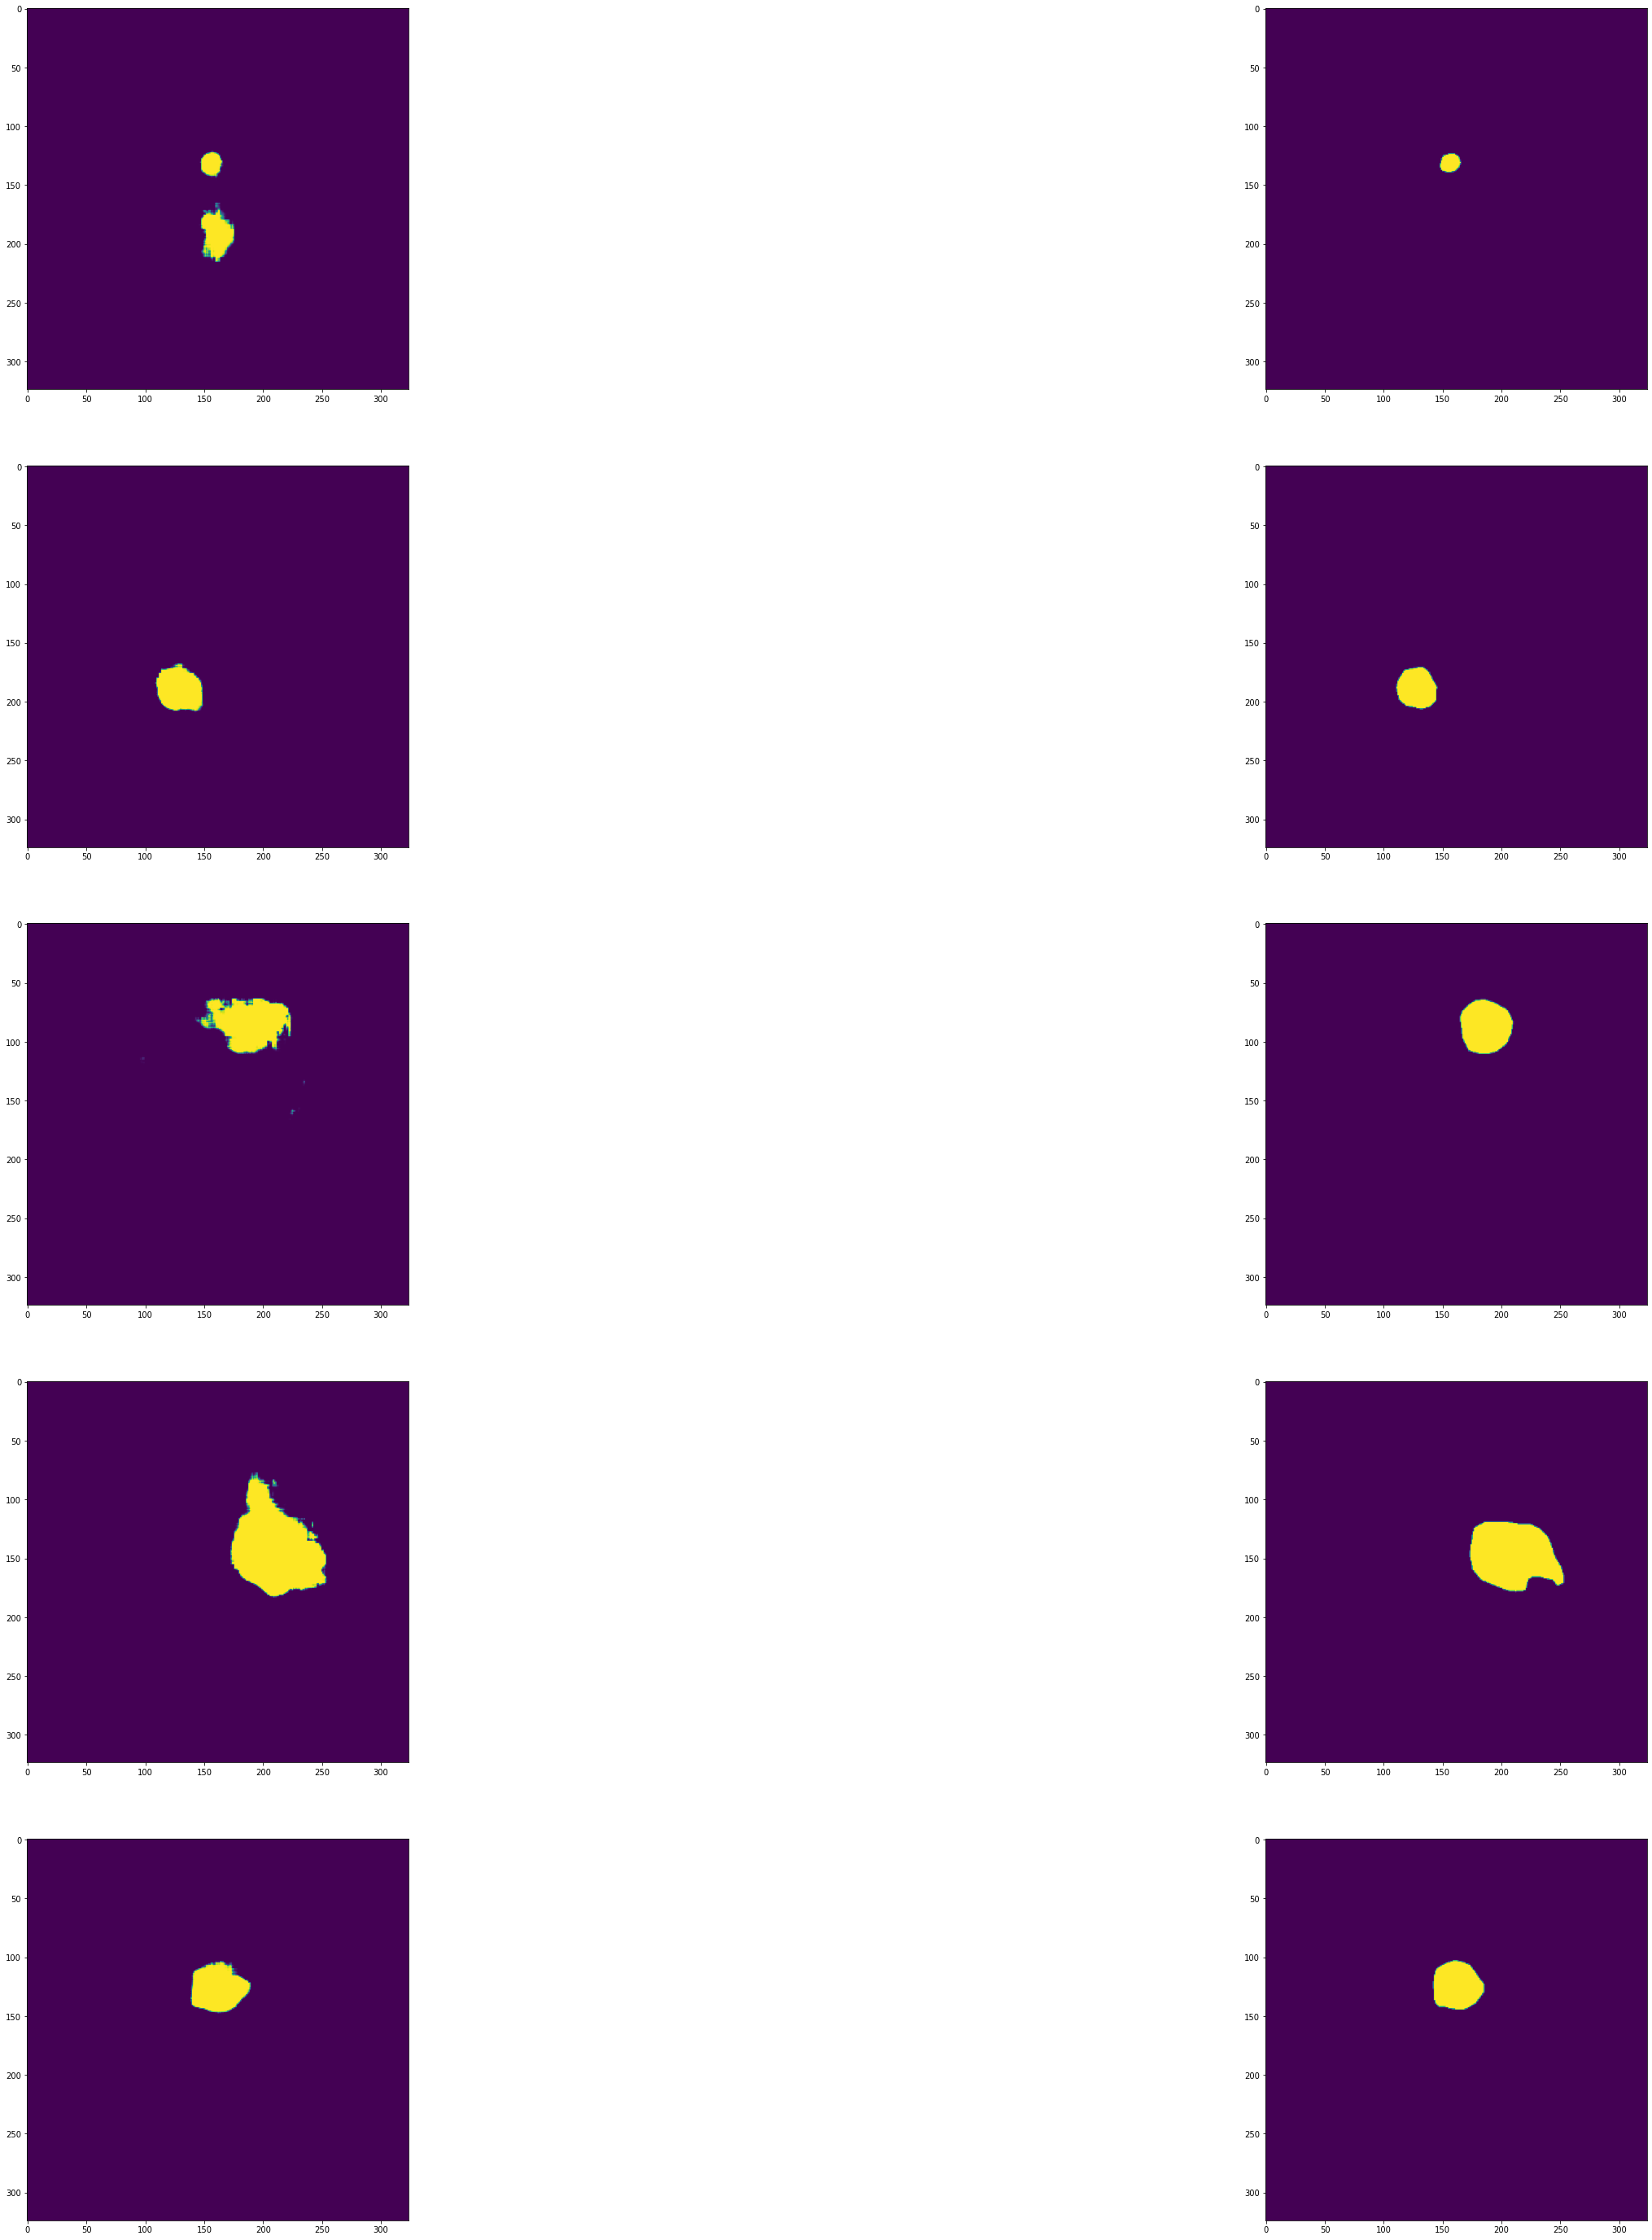

In [146]:
# plot predicted mask(left) vs true mask(right)
fig, axes = plt.subplots(5,2, figsize=(50,50))
for i in range(len(random_index)):
    axes[i][0].imshow(np.reshape(predictions[random_index[i]], (324,324)))
    axes[i][1].imshow(y_test[random_index[i]]);